In [ ]:
import warnings
warnings.filterwarnings("ignore")
import scanpy as sc
import matplotlib.pyplot as plt
import pandas as pd
#from pySankey import sankey
import torch
import scvi


import jax
jax.devices()
from pysankey2 import Sankey


# R interface
from rpy2.robjects import pandas2ri
from rpy2.robjects import r
import rpy2.rinterface_lib.callbacks
import anndata2ri
import rpy2.robjects.numpy2ri
import matplotlib.lines as mlines

#import numpy2ri

pandas2ri.activate()
anndata2ri.activate()
rpy2.robjects.numpy2ri.activate()

%load_ext rpy2.ipython

In [ ]:
adata_herb = sc.read('Data/herb_hypo_ref.h5ad')
print(adata_herb.shape)

adata_herb.layers['log_transformed'] = adata_herb.X

adata_herb.raw = adata_herb.copy()

sc.pp.highly_variable_genes(adata_herb, n_top_genes=3000, 
                            batch_key="reactionID", subset=True)
print(adata_herb.shape)


In [ ]:
# Setup data for scvi and initialize model 
scvi.model.SCVI.setup_anndata(adata_herb, layer="counts", batch_key="reactionID")
vae = scvi.model.SCVI(adata_herb, n_layers=2, gene_likelihood='nb')
vae.train(early_stopping=True, max_epochs=100, train_size=0.75)

In [ ]:
pd.concat([vae.history['elbo_train'], vae.history['elbo_validation']], axis=1).plot.line()
plt.show()

In [5]:
# Use the embedding from scvi to compute neighbors and umap
adata_herb.obsm["X_scVI"] = vae.get_latent_representation()
sc.pp.neighbors(adata_herb, use_rep="X_scVI")
adata_herb.obsm['X_scVI_MDE'] = scvi.model.utils.mde(adata_herb.obsm['X_scVI'])

INFO     Using cuda:0 for `pymde.preserve_neighbors`.                                                              


In [6]:
vae.save("scvi_integration/scvi_global_reference/scvi_herb", overwrite=True, save_anndata=True)

In [2]:
vae = scvi.model.SCVI.load("scvi_integration/scvi_global_reference/scvi_herb")
adata_herb = sc.read("scvi_integration/scvi_global_reference/scvi_herb/adata.h5ad")



INFO     File ../Notebooks/scvi_integration/scvi_herb_6/model.pt already downloaded                                


In [3]:
# Initialize SCANVI model with pretrained scvi model
lvae = scvi.model.SCANVI.from_scvi_model(vae, adata=adata_herb, 
       labels_key="Cell_types_2", unlabeled_category="Unknown")
lvae

INFO     AnnData object appears to be a copy. Attempting to transfer setup.                                        


ScanVI Model with the following params: 
unlabeled_category: Unknown, n_hidden: 128, n_latent: 10, n_layers: 2, dropout_rate: 0.1, dispersion: gene, 
gene_likelihood: nb
Training status: Not Trained
Model's adata is minified?: False

In [4]:
# Training model
lvae.train(max_epochs=70, train_size=0.75,early_stopping=True)

INFO     Training for 70 epochs.                                                                                   


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 70/70: 100%|████████████████████████████████████████| 70/70 [52:09<00:00, 46.29s/it, v_num=1, train_loss_step=2.19e+3, train_loss_epoch=1.34e+3]

`Trainer.fit` stopped: `max_epochs=70` reached.


Epoch 70/70: 100%|████████████████████████████████████████| 70/70 [52:09<00:00, 44.70s/it, v_num=1, train_loss_step=2.19e+3, train_loss_epoch=1.34e+3]


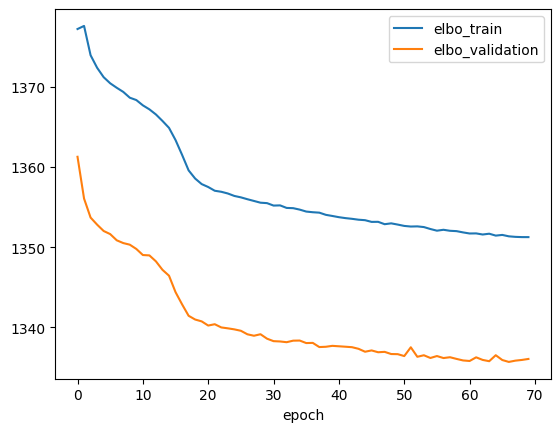

In [5]:
pd.concat([lvae.history['elbo_train'], lvae.history['elbo_validation']], axis=1).plot.line()
plt.show()

In [6]:
# Use the embedding from scvi to compute neighbors and umap
adata_herb.obsm["X_scANVI"] = lvae.get_latent_representation()
sc.pp.neighbors(adata_herb, use_rep="X_scANVI")
adata_herb.obsm["X_scANVI_MDE"] = scvi.model.utils.mde(adata_herb.obsm['X_scANVI'])
#sc.tl.umap(adata_herb)

INFO     Using cuda:0 for `pymde.preserve_neighbors`.                                                              


In [7]:
lvae.save("scvi_integration/scvi_global_reference/scanvi_herb", overwrite=True, save_anndata=True)


# Prediction

In [2]:
adata_herb = sc.read('scvi_integration/scvi_global_reference/scanvi_herb/adata.h5ad')
adata_in_vitro = sc.read('Data/adata_d50_d70_neurons_annotated.h5ad')
#adata_in_vitro.obs['Cell_types_2'] = adata_in_vitro.obs['Cell_types']
adata_in_vitro.obs = adata_in_vitro.obs[['day', 'reactionID', 'Cell_types', 'Cell_types_2', 'diff_batch_2', 'dimensionality']]
adata_in_vitro.obs['source'] = 'in_vitro'
adata_herb.obs['source'] = 'in_vivo'

del adata_in_vitro.var
del adata_in_vitro.obsp

adata_in_vitro.raw = adata_in_vitro.copy()

print(adata_in_vitro.shape)

adata_in_vitro = adata_in_vitro[:, list(set(adata_herb.var_names) & set(adata_in_vitro.var_names))].copy()
adata_in_vitro.obs['annotations'] = adata_in_vitro.obs.Cell_types.copy()
adata_in_vitro.obs['annotations_2'] = adata_in_vitro.obs.Cell_types_2.copy()

adata_in_vitro.obs.Cell_types_2 = 'Unknown'
adata_in_vitro

(33486, 32207)


AnnData object with n_obs × n_vars = 33486 × 2933
    obs: 'day', 'reactionID', 'Cell_types', 'Cell_types_2', 'diff_batch_2', 'dimensionality', 'source', 'annotations', 'annotations_2'
    uns: 'Cell_types_2_colors', 'Cell_types_colors', 'integrated_snn_res.0.1_colors'
    obsm: 'X_pca', 'X_umap'
    layers: 'counts', 'log_transformed'

In [3]:
# Using a pretrained scanvi model
scvi.model.SCANVI.prepare_query_anndata(adata_in_vitro, "scvi_integration/scvi_global_reference/scanvi_herb")
# Initialize model
lvae_q = scvi.model.SCANVI.load_query_data(adata_in_vitro,"scvi_integration/scvi_global_reference/scanvi_herb")
print(lvae_q)
# Train scANVI model
lvae_q.train(max_epochs=30,plan_kwargs=dict(weight_decay=0.0), early_stopping=True, train_size=0.75,check_val_every_n_epoch=10)

INFO     File ../Notebooks/scvi_integration/scanvi_herb_12/model.pt already downloaded                             
INFO     Found 97.76666666666667% reference vars in query data.                                                    
INFO     File ../Notebooks/scvi_integration/scanvi_herb_12/model.pt already downloaded                             


ScanVI Model with the following params: 
unlabeled_category: Unknown, n_hidden: 128, n_latent: 10, n_layers: 2, dropout_rate: 0.1, dispersion: gene, 
gene_likelihood: nb
Training status: Not Trained
Model's adata is minified?: False


INFO     Training for 30 epochs.                                                                                   


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 30/30: 100%|█████████████████████████████████████████████████████████████████████████████| 30/30 [02:24<00:00,  4.97s/it, v_num=1, train_loss_step=2.15e+3, train_loss_epoch=2.13e+3]

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 30/30: 100%|█████████████████████████████████████████████████████████████████████████████| 30/30 [02:24<00:00,  4.82s/it, v_num=1, train_loss_step=2.15e+3, train_loss_epoch=2.13e+3]


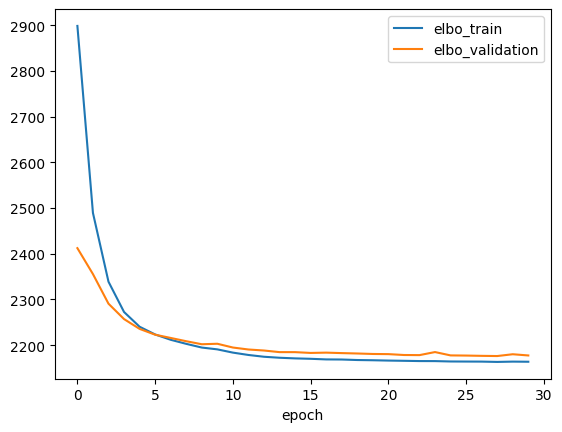

<Figure size 640x480 with 0 Axes>

In [4]:
pd.concat([lvae_q.history['elbo_train'], lvae_q.history['elbo_validation']], axis=1).plot.line()
plt.show()
plt.clf()

# Visualization

In [5]:
# Run prediction
df = lvae_q.predict(soft=True) # Returns a dataframe
# Predict function returns a dataframe
# From row get the cell type with the highest probability and the probability value
data = {"Cell_type":list(df.idxmax(axis=1)), "Probability":list(df.max(axis="columns"))}
# Create a dataframe from this data, cells with prediction score less than 0.6 are filtered away
cell_prob = pd.DataFrame(data) 
adata_in_vitro.obs["Predictions"] = "Unknown"
cell_prob.loc[cell_prob.Probability < 0.6, ['Cell_type']] = 'Unknown'
adata_in_vitro.obs.loc[adata_in_vitro.obs["Predictions"] == "Unknown", "Predictions"] = list(cell_prob["Cell_type"])
#adata_d16.raw = adata_d16_original.copy()
adata_in_vitro.obs["Predictions"].value_counts(normalize=True)

ARC            0.417488
tRGC           0.198531
Unknown        0.132115
Fetal          0.122529
Tanycytes      0.108613
PVH            0.005614
SCN            0.004151
PO             0.003225
Unassigned     0.002120
cRGC           0.002031
LH             0.001463
Endothelial    0.000717
SMN            0.000657
Blood          0.000418
DMH            0.000209
Astrocytes     0.000030
ZI             0.000030
TM             0.000030
Pericytes      0.000030
Name: Predictions, dtype: float64

In [10]:
# Create a cell type X cell type prediction probability dataframe.
res_dict = {}

# Update annotate namings
adata_in_vitro.obs["Predictions"] = adata_in_vitro.obs["Predictions"].apply(lambda x: 'Fetal neuron' if x == 'Fetal' else x)
adata_in_vitro.obs["Predictions"] = adata_in_vitro.obs["Predictions"].apply(lambda x: 'Unclassified' if x == 'Unknown' else x)
adata_in_vitro.obs["Predictions"] = adata_in_vitro.obs["Predictions"].apply(lambda x: 'Unassigned neuron' if x == 'Unassigned' else x)
adata_in_vitro.obs["Predictions"] = adata_in_vitro.obs["Predictions"].apply(lambda x: 'ARC neurons' if x == 'ARC' else x)

adata_herb.obs["Cell_types_2"] = adata_herb.obs["Cell_types_2"].apply(lambda x: 'Fetal neuron' if x == 'Fetal' else x)
adata_herb.obs["Cell_types_2"] = adata_herb.obs["Cell_types_2"].apply(lambda x: 'Unclassified' if x == 'Unknown' else x)
adata_herb.obs["Cell_types_2"] = adata_herb.obs["Cell_types_2"].apply(lambda x: 'Unassigned neuron' if x == 'Unassigned' else x)
adata_herb.obs["Cell_types_2"] = adata_herb.obs["Cell_types_2"].apply(lambda x: 'ARC neurons' if x == 'ARC' else x)


# Get cell types to list from adata and loop over the list
cells = list(adata_in_vitro.obs["annotations"].cat.categories)
for cell in cells:
    # Get the prediction probability values for the cell type
    cell_subset = list(adata_in_vitro.obs[adata_in_vitro.obs["annotations"] == cell].index)
    temp_dict = adata_in_vitro[cell_subset,:].obs["Predictions"].value_counts().to_dict()
    percentage_dict = {}
    
    # Round the value
    for key,value in temp_dict.items():
        value = round((value / len(cell_subset)*100),2)
        if value > 1: percentage_dict.update({key: value })
    
    # Store results to dictionarry
    res_dict.update({cell:percentage_dict})

# Create dataframe from the dict
prediction_df = pd.DataFrame.from_dict(res_dict, orient='index')
prediction_df = prediction_df.fillna(0)
prediction_df = prediction_df.reindex(prediction_df.max(1).sort_values(ascending=True).index)
prediction_df

,ARC neurons,tRGC,Unclassified,Fetal neuron,Tanycytes,cRGC,SCN,PVH,PO,SMN
Telencephalic neurons,35.36,9.36,20.80,15.90,0.00,0.00,6.54,5.5,3.42,1.78
Immature ARC neurons,36.38,12.52,12.89,36.75,0.00,0.00,0.00,0.0,0.00,0.00
ARC neurons,50.40,23.34,14.32,10.02,0.00,0.00,0.00,0.0,0.00,0.00
Tanycytes,2.90,8.66,6.83,6.93,72.59,1.36,0.00,0.0,0.00,0.00


In [12]:
barplot_data = adata_in_vitro.obs['Predictions'].value_counts(normalize=True).to_dict()
#print(list(barplot_data.keys()))
#print(barplot_data)
no_predictions = list(set(adata_herb.obs['Cell_types_2'].cat.categories) - set(barplot_data.keys()))

for key in no_predictions:
    barplot_data.update({key:0})

barplot_data.update((x, y*100) for x, y in barplot_data.items())

barplot_data = pd.DataFrame(barplot_data.items(),columns=['Prediction','Percentage'])
barplot_data["Prediction"] = barplot_data["Prediction"].apply(lambda x: 'Dividing oligo' if x == 'Oligodendrocytes [Dividing]' else x)
barplot_data["Prediction"] = barplot_data["Prediction"].apply(lambda x: 'Immature oligo' if x == 'Oligodendrocytes [Immature]' else x)
barplot_data["Prediction"] = barplot_data["Prediction"].apply(lambda x: 'Intermediate oligo' if x == 'Oligodendrocytes [Intermediate]' else x)
barplot_data["Prediction"] = barplot_data["Prediction"].apply(lambda x: 'Mature oligo' if x == 'Oligodendrocytes [Mature]' else x)

barplot_data

,Prediction,Percentage
0,ARC neurons,41.748791
1,tRGC,19.853073
2,Unclassified,13.211491
3,Fetal neuron,12.252882
4,Tanycytes,10.861255
5,PVH,0.561429
6,SCN,0.415099
7,PO,0.322523
8,Unassigned neuron,0.212029
9,cRGC,0.203070


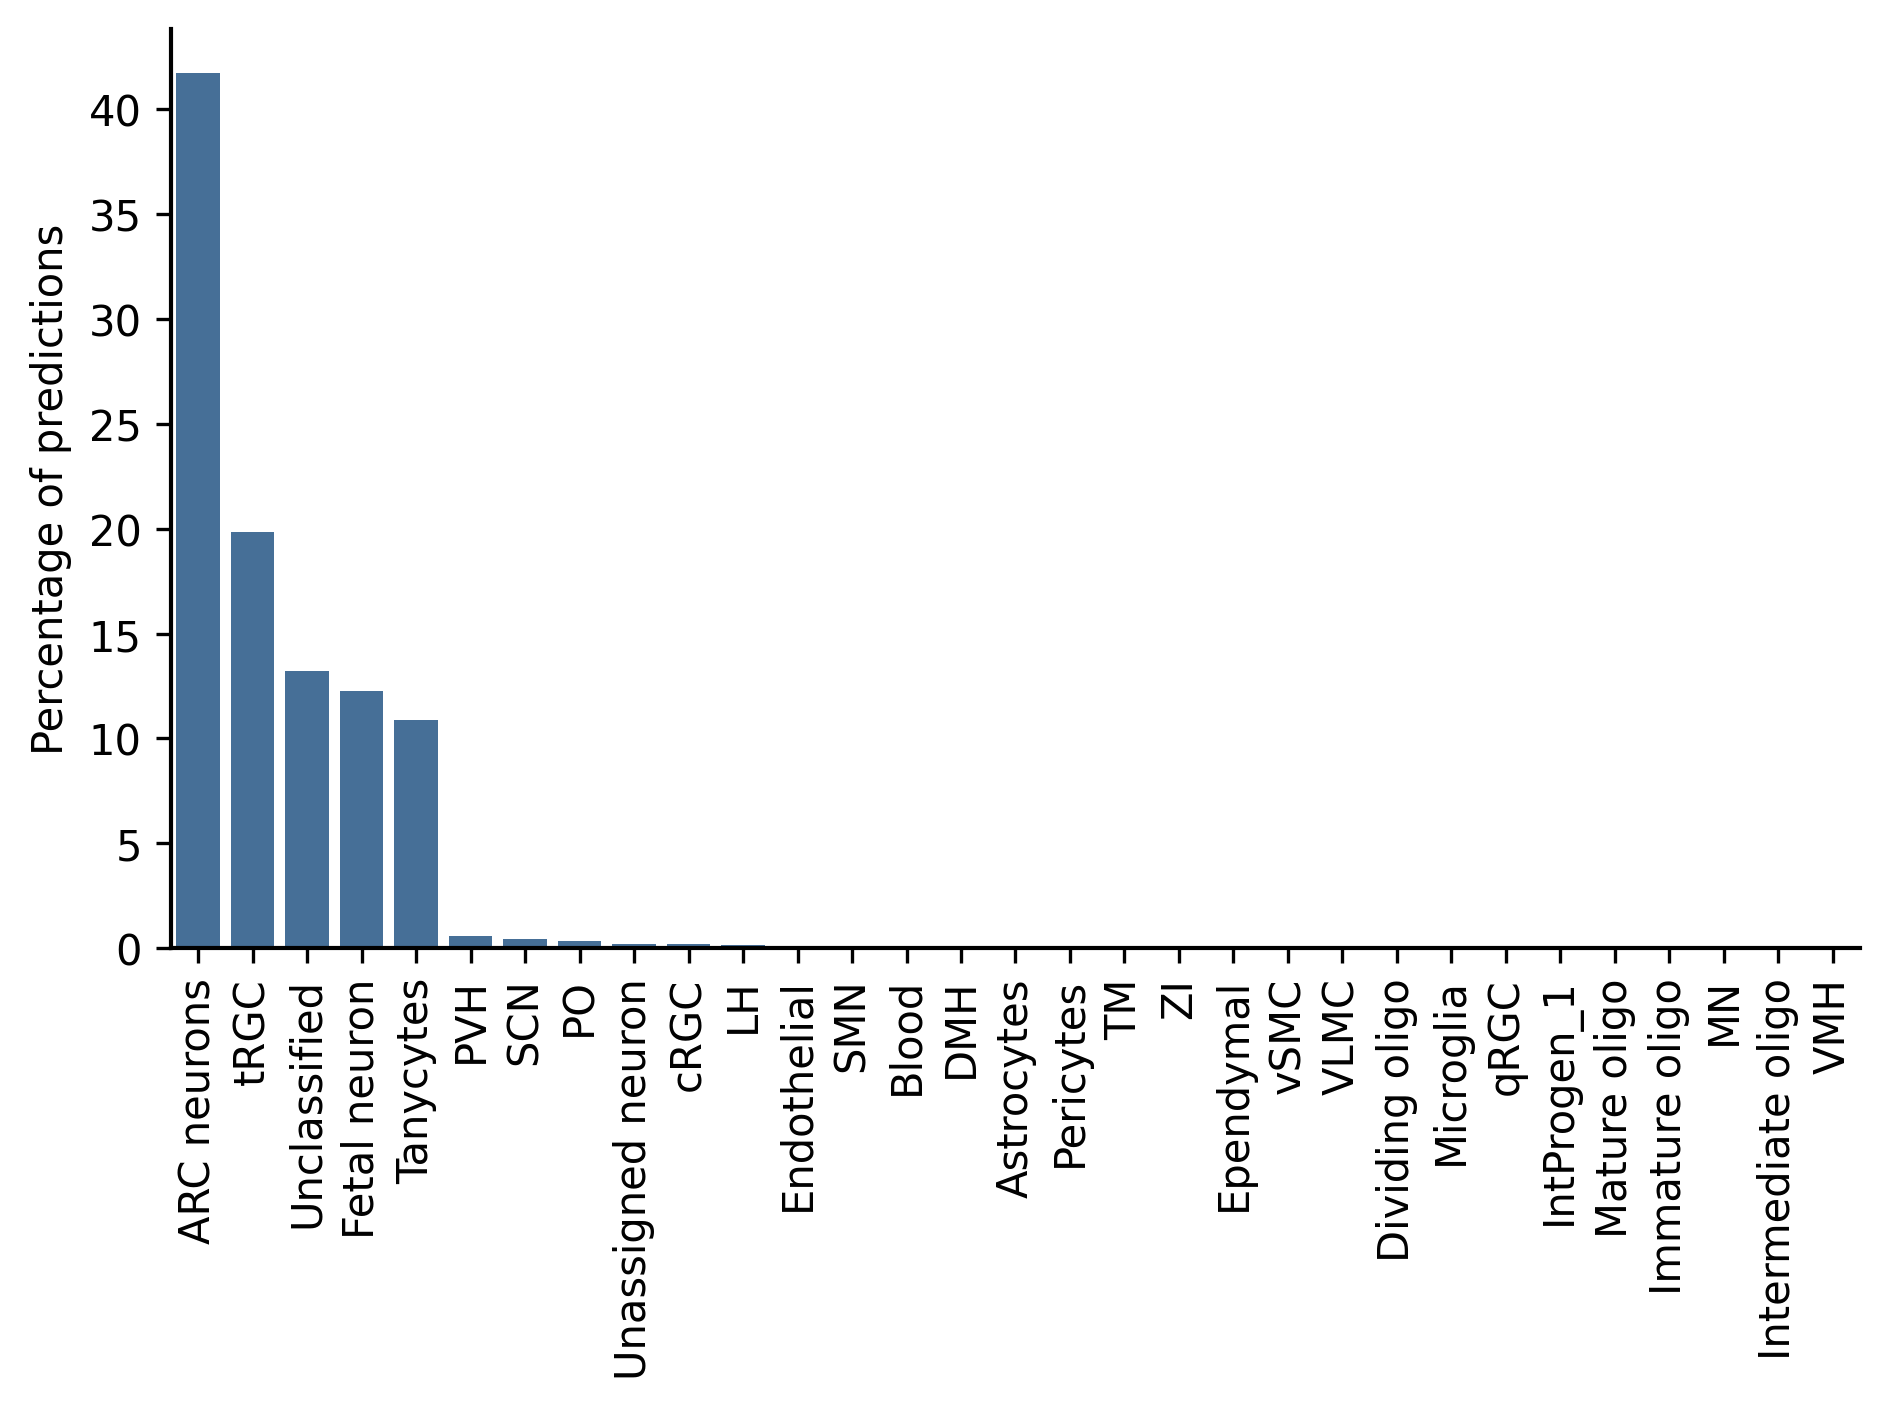

In [26]:
import seaborn as sns
import matplotlib
matplotlib.rcParams['axes.linewidth'] = 1
with plt.rc_context({ "figure.dpi": 300}):  
    barplot_data.plot(kind='bar')
    ax= sns.barplot(barplot_data, x="Prediction", y="Percentage", color='#386fa4')
    plt.legend([],[], frameon=False)
    plt.ylabel('Percentage of predictions')
    plt.xlabel('')
    ax.spines[['right', 'top']].set_visible(False)
    #ax.tick_params(axis='x', rotation=45)
    #ax.spines[['left','bottom']].set(lw=0.2)
    plt.tight_layout()
    #ax.savefig('figures/percentage_of_predictions.png')
    plt.savefig('figures/percentage_of_predictions.pdf') 
    plt.show()

In [ ]:
counts = adata_in_vitro.obs["Predictions"].value_counts(normalize=True)
cell_types = counts[counts>0.005].index.tolist()
adata_temp = adata_in_vitro[adata_in_vitro.obs.Predictions.isin(cell_types)]

sc.tl.embedding_density(adata_temp, groupby='Predictions')

with plt.rc_context({ "figure.dpi": 300, "figure.figsize": (4,4)}):
    for group in cell_types:
        sc.pl.embedding_density(adata_temp,key='umap_density_Predictions', group=[group],ncols=1, 
        frameon=False,fg_dotsize=80, save=f'_{group}_predictions.pdf')    

In [100]:
from pysankey2.utils import setColorConf
adata_in_vitro_cell_type_colors = ['#EF6B46','#3A89BE','#FAAA4E','#EDDB7E','#E73F3F']

counts = adata_in_vitro.obs["Predictions"].value_counts(normalize=True)
cell_types = counts[counts>0.01].index.tolist()

print(cell_types)

sankey_data = adata_in_vitro.obs[['annotations','Predictions']]
sankey_data = sankey_data[sankey_data.Predictions.isin(cell_types)]

prediction_colors =  setColorConf(len(list(set(sankey_data.Predictions))),colors='Accent')


annotation_colors = {}
for i in range(0, len(list(adata_in_vitro.obs.annotations.cat.categories))):
    annotation_colors.update({adata_in_vitro.obs.annotations.cat.categories[i]:adata_in_vitro_cell_type_colors[i]})
    
for i in range(0,len(list(prediction_colors))):
    if list(set(sankey_data.Predictions.values))[i] not in annotation_colors.keys():
        annotation_colors.update({list(set(sankey_data.Predictions.values))[i]:prediction_colors[i]})
print(annotation_colors)

['ARC neurons', 'tRGC', 'Unclassified', 'Fetal neuron', 'Tanycytes']
{'ARC neurons': '#EF6B46', 'Immature ARC neurons': '#3A89BE', 'Tanycytes': '#FAAA4E', 'Telencephalic neurons': '#EDDB7E', 'tRGC': '#7fc97f', 'Unclassified': '#beaed4', 'Fetal neuron': '#fdc086'}


In [101]:
from collections import defaultdict
from collections import OrderedDict
from copy import deepcopy
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import to_hex
from pysankey2 import Sankey

import numpy as np
import pandas as pd
import math
#from .utils import setColorConf,listRemoveNAN

def setColorConf(ngroups,colors="tab20",alternative="grey")->list:
    """
    Parameters:
    ----------
    ngroups:int
        Number of tags need to be colored.
    
    colors:str
        Built-in colormaps accessible in the matplotlib.
        See more:https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html
    
    alternative:
        If <ngroups> is greater than the maximum number of colorPalette, the rest tags would be colored with <alternative>.
    
    Returns:
    --------
    colors_list:list
        a list of colors(hex).
    """ 
    if colors == "hcl":
        try:
            from colorspace import sequential_hcl
            color_repo = sequential_hcl(h=[15,375],l=65,c=70)
            colors_list =  color_repo.colors(ngroups + 1)
        except ImportError:
            print('hcl colorspace package has not being installed.')
            print('please try the following command:')
            print('pip install git+https://github.com/retostauffer/python-colorspace') 
    else:
        colors = list(plt.get_cmap(colors).colors)
        colors_list = [to_hex(color) for color in colors]
        colors_list = colors_list[:ngroups]

        # if len of colors_list less than ngroups, use grey to fullfill.
        if len(colors_list) < ngroups:
            for i in range(ngroups - len(colors_list)):
                colors_list.append(to_hex(alternative))
    return colors_list

def listRemoveNAN(list_):
    """
    Remove NaN in the list.
    list_:list-like object.
    """
    list_new = []
    for i,val in enumerate(list(list_)):
        # float/nan
        if isinstance(val,float): 
            if math.isnan(val):
                continue
            else:
                list_new.append(val)
        # int,str,etc.
        else:
            list_new.append(val)
    return list_new

__all__ = ['Sankey','LabelMismatchError']

class SankeyException(Exception):
    pass

class LabelMismatchError(SankeyException):
    """LabelMismatchError is thrown when the provided labels are different from the labels in the dataframe."""
    pass

class Sankey2:
    """
    Static Sankey diagram based on matplotlib.
    pySankey2 currently supports 2-layer and multi-layer Sankey diagram, where user can freely set the box position, strip length, etc.
    The returned matplotlib.figure and matplotlib.axes object allows post modification using matplotlib api.
    """
    def __init__(self,dataFrame,layerLabels=None,colorDict=None,colorMode="global",stripColor="grey"):
        """
        Parameters:
        -----------
        dataFrame:pd.DataFrame
            Each row of the dataFrame represents a trans-entity,
        
        layerLabels:dict
            If passing, the provided layerLabels would determine the drawing order of each layer.
            If passing, dict keys must be named corresponding to column names of dataFrame.
                e.g {'layer1':['label1','label2','label4'],'layer2':['label2','label5','label6']}
            If not passing, layerLabels would be extracted from the dataFrame.
        
        colorDict:dict
            There are 2 modes can be passing, see colorMode for details.

        colorMode:str, Can only take option in ["global","layer"].
            If choosing "global", a colorPalette dict that merged the same label in different layers would be taken.
            If choosing "layer", a colorPalette dict that treat the same label in different layers as independent label would be taken.
            For example, a layerLabels was: 
                layerLabels = ['layer1':['label1','label2','label3'],'layer2':['label1','label4']].
            If choosing "global", colorPalette(aka colorDict) like:
                {'label1':'some color','label2':'some color','label3':'some color','label4':'some color'} would be taken. 
            If choosing "layer", colorPalette(aka colorDict) like:
                {'layer1':{'label1':'some color','label2':'some color','label3':'some color'},
                 'layer2':{'label1':'some color','label4':'some color'}} would be taken. 

        stripColor:str, specified strip color.
            Default is "grey".
            If choosing "left": The color of strip would be the same as the box on the left.
            Specified colors would be passed into  plt.fill_between().
        """

        self.dataFrame = deepcopy(dataFrame)
        # get mapping between old and new column names & rename columns.
        self._colnameMaps = self._getColnamesMapping(self.dataFrame)
        self.dataFrame.columns = ['layer%d'%(i+1) for i in range(dataFrame.shape[1])]

        # labels
        self._allLabels = self._getAllLabels(self.dataFrame)
        if layerLabels is None:
            self._layerLabels = self._getLayerLabels(self.dataFrame)
        else:
            self._checkLayerLabelsMatchDF(self.dataFrame,layerLabels,self._colnameMaps)
            self._layerLabels = layerLabels
        
        # colors
        self.colorMode = colorMode
        _opts=["global","layer"]
        if colorMode not in _opts:
            raise ValueError("colorMode options must be one of:{0} ".format(",".join([i for i in _opts])))       
        if colorDict is None:
            self._colorDict = self._setColorDict(self._layerLabels,mode = colorMode)
        else:
            self._checkColorMatchLabels(colorDict,mode = colorMode)
            if colorMode == "layer":
                colorDict = self._renameColorDict(colorDict)
            self._colorDict = colorDict

        # stripColor
        self._stripColor = stripColor

    def _getColnamesMapping(self,dataFrame):
        """
        Returns:
        -------
        dict: mapping relationship between old and new names.
        """
        return dict(zip(dataFrame.columns,['layer%d'%(i+1) for i in range(dataFrame.shape[1])]))
    
    def _getAllLabels(self,dataFrame):
        """
        Returns:
        -------
        allLabels:list
            a global unique label list.
        """
        uniqLabels = list(set(dataFrame.unstack().values))
        allLabels = listRemoveNAN(uniqLabels)
        return allLabels

    def _getLayerLabels(self,dataFrame):
        """
        Returns:
        -------
        layerLabels:dict
            a layer-specific unique label dict(same labels in different layers would be treated as independent labels).
        """
        layerLabels = OrderedDict()
        for layer_label in dataFrame.columns:
            layer_labels = list(dataFrame.loc[:,layer_label].unique()) # may contain NaN
            layer_labels = listRemoveNAN(layer_labels)
            layerLabels[layer_label] = layer_labels
        return layerLabels

    def _checkLayerLabelsMatchDF(self,dataFrame,layerLabels,colnameMaps):
        """
        check whether the provided layer-specific labels match dataframe column names.
        """
        for oldname,newname in colnameMaps.items():
            df_list = listRemoveNAN(dataFrame.loc[:,newname].unique())
            provided_list = listRemoveNAN(layerLabels[oldname])
            df_set = set(df_list)
            provided_set = set(provided_list)

            if df_set != provided_set:
                msg_df = "dataFrame Labels:" + ",".join([str(i) for i in df_set]) + "\n"
                msg_provided = "Provided Labels:" + ",".join([str(i) for i in provided_set]) + "\n"
                raise LabelMismatchError('{0} do not match with {1}'.format(msg_provided, msg_df))
            

    def _checkColorMatchLabels(self,colorDict,mode):
        """
        check if labels in provided colorDict are identical to those in dataFrame.
        """
        if mode == "global":
            provided_set = set(colorDict.keys())
            df_set = set(self.labels)
            if provided_set !=df_set:
                msg_provided = "Provided Color Labels:" + ",".join([str(i) for i in provided_set]) + "\n"
                msg_df = "dataFrame Labels:" + ",".join([str(i) for i in df_set]) + "\n"
                raise LabelMismatchError('{0} do not match with {1}'.format(msg_provided, msg_df))     
        elif mode == "layer":
            # whether layer-specific labels match layerLabels
            for old_layer,layer_labels_map in colorDict.items():
                provided_set = set(layer_labels_map.keys())
                new_layer = self._colnameMaps[old_layer]
                df_set = set(self.layerLabels[new_layer])
                if provided_set !=df_set:
                    msg_provided = "Provided Color Labels:" + ",".join([str(i) for i in provided_set]) + "\n"
                    msg_df = "dataFrame Labels:" + ",".join([str(i) for i in df_set]) + "\n"
                    raise LabelMismatchError('In {0},{1} do not match with {1}'.format(new_layer,msg_provided, msg_df))            
    
    def _setColorDict(self,layerLabels,mode):
        """
        Set color for each label, return a color palette(dict). 
        """

        if mode =="global":
            ngroups = len(self.labels)
            colorPalette = setColorConf(ngroups=ngroups)
            colorDict = {}
            for i, label in enumerate(self.labels):
                colorDict[label] = colorPalette[i]
        elif mode =="layer":
            all_layer_labels = []
            for layer,layer_labels in self.layerLabels.items():
                all_layer_labels +=layer_labels
            
            ngroups = len(all_layer_labels)
            colorPalette = setColorConf(ngroups=ngroups)
            colorDict = defaultdict(dict)
            i=0
            for layer,layer_labels in self.layerLabels.items():
                for layer_label in layer_labels:
                    colorDict[layer][layer_label] = colorPalette[i]
                    i+=1
        return colorDict

    def _renameColorDict(self,colorDict):
        """rename keys of colordict from old column names to 'layer'"""
        for old_name,new_name in self.colnameMaps.items():
            if old_name == new_name:
                continue
            else:
                colorDict[new_name]=colorDict[old_name]
                del colorDict[old_name]
        return colorDict

    def _setboxPos(self,dataFrame,layerLabels,boxInterv):
        """
        Set y-axis coordinate position for each box.
        Returns:
        -------
        boxPos:dict, contain y-axis position of each box.
        """
        boxPos = OrderedDict()
        for layer,labels in layerLabels.items():
            layerPos = defaultdict(dict)
            for i,label in enumerate(labels):
                labelHeight = ((dataFrame[dataFrame.loc[:,layer] == label])
                            .loc[:,layer]
                            .count())
                if i ==0:
                    layerPos[label]['bottom'] = 0
                    layerPos[label]['top'] = labelHeight
                else:
                    prevLabelTop = layerPos[labels[i-1]]['top']
                    layerPos[label]['bottom'] = prevLabelTop + boxInterv * dataFrame.loc[:,layer].count()
                    layerPos[label]['top'] = layerPos[label]['bottom'] + labelHeight
            boxPos[layer] = layerPos
        
        return boxPos    
    
    def _setLayerPos(self,layerLabels,boxWidth,stripLen):
        """
        Set x-axis coordinate position for each layer.        
        Returns:
        --------
        layerPos:dict, contain x-axis position of each layer.
        """
        layerPos = defaultdict(dict) 
        layerStart = 0
        layerEnd = 0 + boxWidth

        for layer in layerLabels.keys():
            layerPos[layer]['layerStart'] = layerStart
            layerPos[layer]['layerEnd'] = layerEnd     

            layerStart = (layerEnd + stripLen)     
            layerEnd = (layerStart + boxWidth)
        return layerPos

    def _setStripWidth(self,layerLabels,dataFrame):
        """
        Set the width of strip(i.e. the size of a transfer pair).
        Returns:
        -------
        stripWidths:nested dict, stripWidths['layer'][leftLabel][rightLabel] = width: 
           <leftLabel> in 'layer' has a link with <rightLabel>(in the next layer) , where the size/width of link equals <width>.

        """
        layers = list(layerLabels.keys())
        # nested dict,see more:https://stackoverflow.com/questions/19189274/nested-defaultdict-of-defaultdict
        stripWidths = defaultdict(lambda: defaultdict(dict))

        for i,layer in enumerate(layers):
            # the last layer
            if i == len(layers) -1:
                break
            
            leftLayer = layers[i]
            rightLayer = layers[i+1]
            for leftLabel in layerLabels[leftLayer]:
                for rightLabel in layerLabels[rightLayer]:
                    width = len(dataFrame[(dataFrame.loc[:,leftLayer] == leftLabel) & (dataFrame.loc[:,rightLayer] == rightLabel)])
                    if width >0:
                        stripWidths[leftLayer][leftLabel][rightLabel] = width

        return stripWidths
            
    def _setStripPos(self,leftBottom,rightBottom,leftTop,rightTop,kernelSize,stripShrink):
        """
        Smooth the strip by convolution, and create array of y values for each strip.
        """
        ys_bottom = np.array(50 * [leftBottom] + 50 * [rightBottom])
        ys_bottom = np.convolve(ys_bottom + stripShrink, (1/kernelSize) * np.ones(kernelSize), mode='valid')
        ys_bottom = np.convolve(ys_bottom + stripShrink, (1/kernelSize) * np.ones(kernelSize), mode='valid')
        
        ys_top = np.array(50 * [leftTop] + 50 * [rightTop])
        ys_top = np.convolve(ys_top - stripShrink, (1/kernelSize) * np.ones(kernelSize), mode='valid')
        ys_top = np.convolve(ys_top - stripShrink,(1/kernelSize) * np.ones(kernelSize), mode='valid')    

        return ys_bottom,ys_top

    def _plotBox(self,ax,boxPos,layerPos,layerLabels,colorDict,fontSize,fontPos,box_kws,text_kws):
        """
        Render the box according to box-position(boxPos) and layer-position(layerPos).
        """    

        for layer,labels in layerLabels.items():
            for label in labels:
                labelBot = boxPos[layer][label]['bottom']
                labelTop = boxPos[layer][label]['top']
                layerStart = layerPos[layer]['layerStart']
                layerEnd = layerPos[layer]['layerEnd']

                if self.colorMode == "global":color = colorDict[label]
                elif self.colorMode == "layer":color = colorDict[layer][label]
                # fill the box
                ax.fill_between(
                    x = [layerStart,layerEnd],
                    y1 = labelBot,
                    y2 = labelTop,
                    facecolor = color,
                    alpha = 0.9,
                    **box_kws
                )
                print(layer)
                print(labels)
                # text annotation of each box
                distToBoxLeft = fontPos[0]
                distToBoxBottom = fontPos[1]
                if layer == 'layer1':
                    ax.text(
                        (layerStart + distToBoxLeft),
                        (labelBot + (labelTop - labelBot)* distToBoxBottom),
                        label,
                        {'ha': 'right', 'va': 'center'},
                        fontsize=fontSize,
                        **text_kws)
                elif layer == 'layer2':
                    ax.text(
                        (layerEnd + 0.08),
                        (labelBot + (labelTop - labelBot)* distToBoxBottom),
                        label,
                        #{'ha': 'right', 'va': 'center'},
                        fontsize=fontSize,
                        **text_kws)

    def _plotStrip(self,ax,
                    dataFrame,
                    layerLabels,
                    boxPos,layerPos,
                    stripWidths,kernelSize,
                    stripShrink,stripColor,strip_kws):
        """
        Render the strip according to box-position(boxPos), layer-position(layerPos) and strip width(stripWidths).
        """
        layers = list(layerLabels.keys())
        for i,layer in enumerate(layers):
            # the last layer does not need strip.
            if i == len(layers) -1:
                break
            leftLayer = layers[i]
            rightLayer = layers[i+1]
            # deepcopy:https://zhuanlan.zhihu.com/p/61904991
            # Update the box position when iterated to the next layer,
            # to make sure operation in the last layer would not affect the next layer.
            boxPosProxy = deepcopy(boxPos)
            for leftLabel in layerLabels[leftLayer]:
                for rightLabel in layerLabels[rightLayer]:
                    width = len(dataFrame[(dataFrame.loc[:,leftLayer] == leftLabel) & (dataFrame.loc[:,rightLayer] == rightLabel)])
                    if width > 0:
                        leftBottom = boxPosProxy[leftLayer][leftLabel]['bottom']
                        leftTop = leftBottom + stripWidths[layer][leftLabel][rightLabel] 

                        rightBottom = boxPosProxy[rightLayer][rightLabel]['bottom']
                        rightTop = rightBottom + stripWidths[layer][leftLabel][rightLabel] 

                        ys_bottom,ys_top = self._setStripPos(leftBottom,rightBottom,leftTop,rightTop,kernelSize = kernelSize,stripShrink = stripShrink)
                        
                        # Update bottom edges at each label so next strip starts at the right place
                        boxPosProxy[leftLayer][leftLabel]['bottom'] = leftTop
                        boxPosProxy[rightLayer][rightLabel]['bottom'] = rightTop
                        
                        # X axis of layer.
                        x_start = layerPos[leftLayer]['layerEnd']
                        x_end = layerPos[rightLayer]['layerStart']

                        if stripColor =="left":
                            if self.colorMode == "global":
                                ax.fill_between(
                                    np.linspace(x_start, x_end, len(ys_top)), ys_bottom, ys_top, alpha=0.4,
                                    color=self.colorDict[leftLabel],
                                    #edgecolor='black',
                                    **strip_kws
                                )
                            elif self.colorMode == "layer":
                                ax.fill_between(
                                    np.linspace(x_start, x_end, len(ys_top)), ys_bottom, ys_top, alpha=0.4,
                                    color=self.colorDict[leftLayer][leftLabel],
                                    #edgecolor='black',
                                    **strip_kws
                                )
                        else:
                            ax.fill_between(
                                np.linspace(x_start, x_end, len(ys_top)), ys_bottom, ys_top, alpha=0.4,
                                color=stripColor,
                                #edgecolor='black',
                                **strip_kws
                            )

    def plot(self,figSize=(10,10),
                    fontSize=10,fontPos=(-0.15,0.5),
                    boxInterv=0.02,
                    boxWidth=2,stripLen=10,
                    kernelSize=25,stripShrink=0,
                    box_kws=None,text_kws=None,strip_kws=None,
                    savePath=None):
        """
        Parameters:
        ----------   
        figSize:(float, float), default=(10,10).
            Width, height of figure in inches.

        fontSize:float, default=10.
            Size of font.

        fontPos:(float, float), default=(-0.15,0.5).
            Distance(calculated as a percentage) to the left/bottom of box.
            For example, -0.15 means that the real distance to the left of the box is -0.15 * boxWidth, and 
            the real distance to the bottom of the box is 0.5 * boxHeight.

        boxInterv:float, default=0.02.
            Vertical interval distance between boxes in the same layer.

        boxWidth:float, default=2.
            Width of layer.
        
        stripLen:float, default=10.
            Length of strip.
        
        kernelSize:int, default=25.
            Convolution kernel size, used to control the smoothness of strip, 
        
        stripShrink:float,default=0.
            Shrink extend of strip, used to compress the strip width.
        
        box_kws:
            Additional keyword arguments, which would be passed to plt.fill_between().

        text_kws:
            Additional keyword arguments, which would be passed to plt.text().
        
        strip_kws:
            Additional keyword arguments, which would be passed to plt.fill_between().

        savePath:
            name to save the figure.
        
        Returns:
        --------
        fig:matplotlib Figure.
            The Figure object containing the plot.
        
        ax:matplotlib Axes
            The Axes object containing the plot.
        """
        # set box position
        self._boxPos = self._setboxPos(self.dataFrame,
                                        self._layerLabels,
                                        boxInterv = boxInterv)
        # set layer position
        self._layerPos = self._setLayerPos(self._layerLabels,
                                            boxWidth = boxWidth , 
                                            stripLen = stripLen)
        # set strip width
        self._stripWidths = self._setStripWidth(self._layerLabels,
                                                self.dataFrame)

        plt.rc('text', usetex=False)
        plt.rc('font', family='Arial')
        fig = plt.figure(figsize = figSize)
        ax = fig.subplots()

        # plot box
        if box_kws is None:box_kws = {} 
        if text_kws is None:text_kws = {}
        if not isinstance(box_kws,dict):
            raise TypeError("box_kws must be dict.")
        if not isinstance(text_kws,dict):
            raise TypeError("text_kws must be dict.")
        
        distToBoxLeft = boxWidth * fontPos[0]
        distToBoxBottom = fontPos[1]
        self._plotBox(ax,
                      self._boxPos,
                      self._layerPos,
                      self._layerLabels,
                      self._colorDict,
                      fontSize = fontSize,
                      fontPos = (distToBoxLeft,distToBoxBottom),
                      box_kws = box_kws,
                      text_kws = text_kws)

        # plot strip
        if strip_kws is None:strip_kws = {}
        if not isinstance(strip_kws,dict):
            raise TypeError("strip_kws must be dict.")
        self._plotStrip(ax,
                        self.dataFrame,
                        self._layerLabels,
                        self._boxPos,
                        self._layerPos,
                        self._stripWidths,
                        kernelSize,
                        stripShrink,
                        self._stripColor,
                        strip_kws)
        plt.gca().axis('off')

        if savePath != None:
            plt.savefig(savePath, bbox_inches='tight', dpi=800)
        
        return fig,ax

    @property
    def colnameMaps(self):
        """
        dict, mapping between old and new dataFrame names(e.g. {'old_colname1':'layer1','old_colname2':'layer2'})        
        """

        return self._colnameMaps
    
    @property
    def labels(self):
        """
        list, set of labels in the data.
        """
        return self._allLabels

    @property
    def layerLabels(self):
        """
        dict, set of layer specific labels in the data.(e.g. {'layer1':['label1','label2','label4'],'layer2':['label1','label3','label5']})
        """
        return self._layerLabels
    
    @property
    def boxPos(self):
        """
        dict, contain y-axis position of each box:
            boxPos['layer']['label']['bottom']:bottom position of 'label' in 'layer'.
            boxPos['layer']['label']['top']:top position of 'label' in 'layer'.        
        """
        return self._boxPos

    @property
    def layerPos(self):
        """
        dict, contain x-axis position of each layer:
            layerPos['layer']['layerStart']:start position of x-axis for 'layer'.
            layerPos['layer']['layerEnd']:end position of x-axis for 'layer'.       
        """
        return self._layerPos
    
    @property
    def stripWidth(self):
        """
        dict, stripWidths['layer'][leftLabel][rightLabel] = width: 
           <leftLabel> in 'layer' has a link with <rightLabel>(in the next layer) , where the size/width of link equals <width>.        
        """
        return self._stripWidths
    

    @property
    def colorDict(self):
        """
        dict, see doc strings of colorMode in __init__ for details.
        """
        return self._colorDict        

    @property
    def stripColor(self):
        """see doc strings of stripColor in __init__ for details."""
        return self._stripColor 

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

layer1
['ARC neurons', 'Tanycytes', 'Immature ARC neurons', 'Telencephalic neurons']
layer1
['ARC neurons', 'Tanycytes', 'Immature ARC neurons', 'Telencephalic neurons']
layer1
['ARC neurons', 'Tanycytes', 'Immature ARC neurons', 'Telencephalic neurons']
layer1
['ARC neurons', 'Tanycytes', 'Immature ARC neurons', 'Telencephalic neurons']
layer2
['Unclassified', 'Fetal neuron', 'ARC neurons', 'tRGC', 'Tanycytes']
layer2
['Unclassified', 'Fetal neuron', 'ARC neurons', 'tRGC', 'Tanycytes']
layer2
['Unclassified', 'Fetal neuron', 'ARC neurons', 'tRGC', 'Tanycytes']
layer2
['Unclassified', 'Fetal neuron', 'ARC neurons', 'tRGC', 'Tanycytes']
layer2
['Unclassified', 'Fetal neuron', 'ARC neurons', 'tRGC', 'Tanycytes']


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

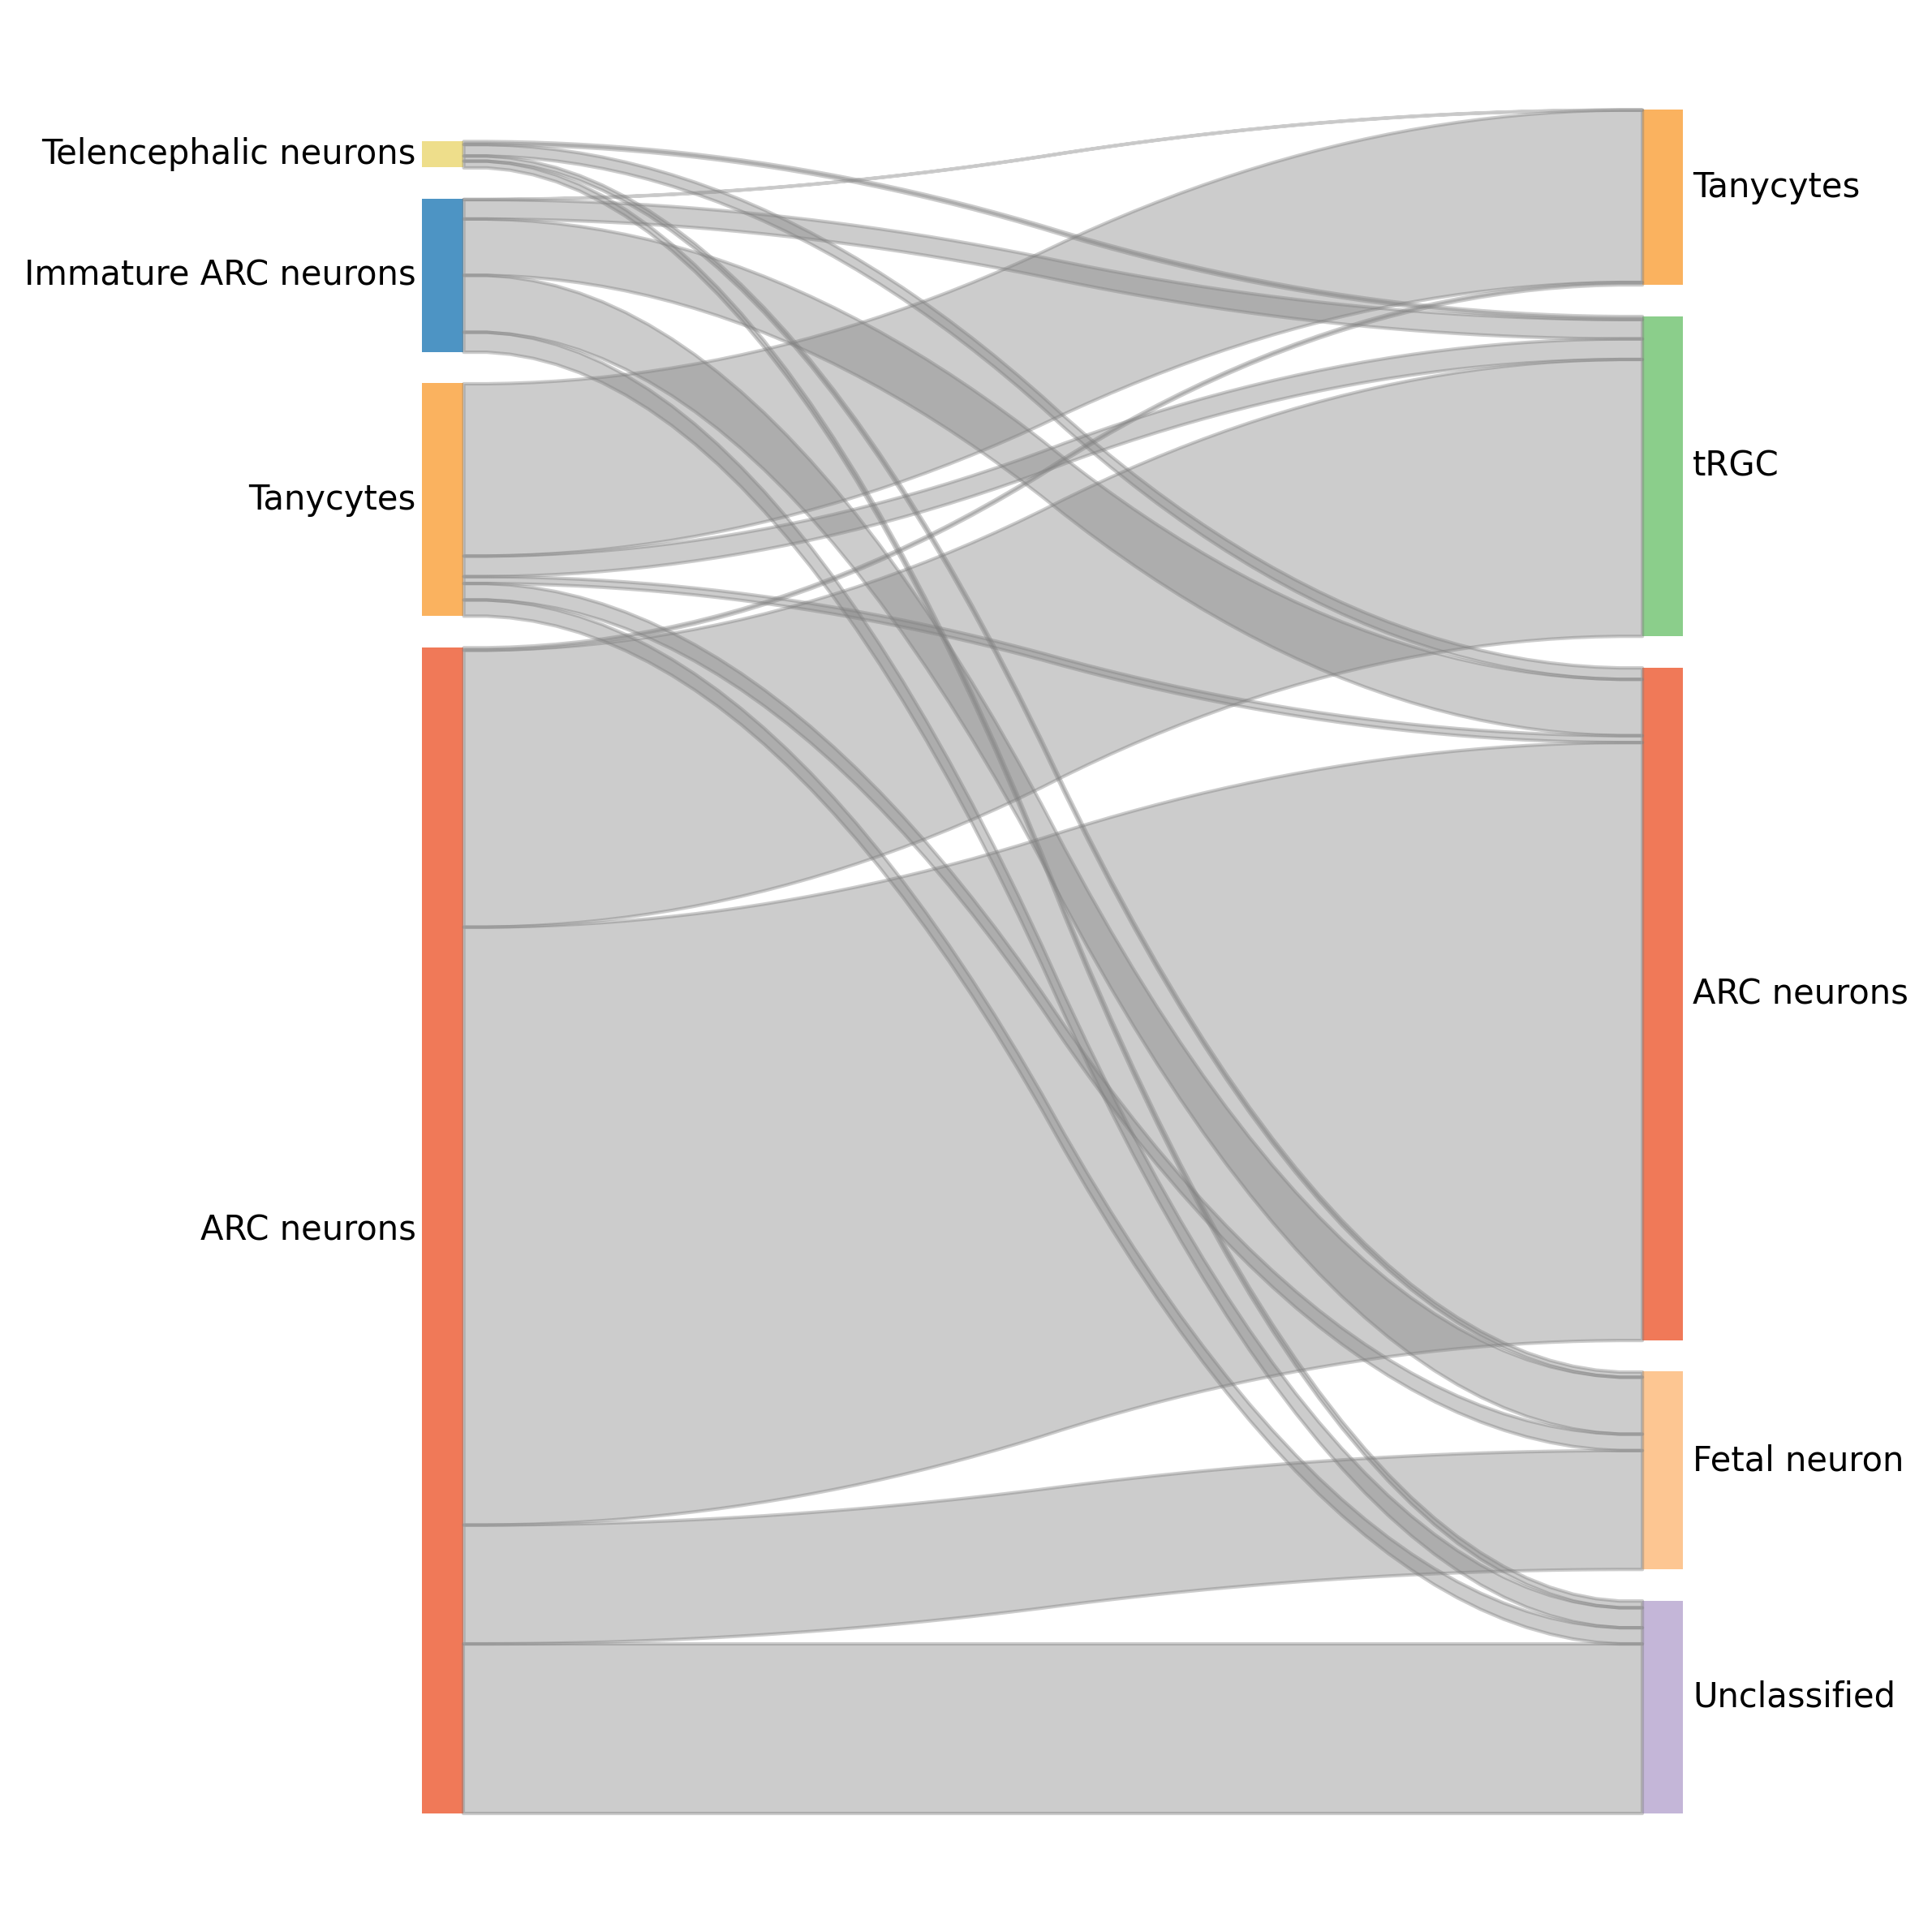

In [120]:
with plt.rc_context({"figure.dpi": (300)}):
    sky = Sankey2(sankey_data,colorMode="global", colorDict=annotation_colors)
    fig,ax = sky.plot(boxWidth=0.35,stripLen=10,figSize=(8, 8))
    plt.tight_layout()  
    #plt.savefig('prediction_sankey.png',)
    plt.savefig('prediction_sankey.pdf')
    plt.show()
    

In [103]:
lvae_q.save("scvi_integration/scvi_global_reference/scanvi_ref_mapping", overwrite=True, save_anndata=True)


# Projecting the query to the herb reference

In [ ]:
adata_in_vitro = sc.read('scvi_integration/scvi_global_reference/scanvi_ref_mapping/adata.h5ad')
adata_herb = sc.read('scvi_integration/scvi_global_reference/scanvi_herb/adata.h5ad')
lvae_q = scvi.model.SCANVI.load("scvi_integration/scvi_global_reference/scanvi_ref_mapping")

In [64]:
# Rename clusters in herb
adata_herb.obs["Cell_types_2"] = adata_herb.obs["Cell_types_2"].apply(lambda x: 'Fetal neuron' if x == 'Fetal' else x)
adata_herb.obs["Cell_types_2"] = adata_herb.obs["Cell_types_2"].apply(lambda x: 'Unassigned neuron' if x == 'Unassigned' else x)
adata_herb.obs["Cell_types_2"] = adata_herb.obs["Cell_types_2"].apply(lambda x: 'Dividing oligo' if x == 'Oligodendrocytes [Dividing]' else x)
adata_herb.obs["Cell_types_2"] = adata_herb.obs["Cell_types_2"].apply(lambda x: 'Immature oligo' if x == 'Oligodendrocytes [Immature]' else x)
adata_herb.obs["Cell_types_2"] = adata_herb.obs["Cell_types_2"].apply(lambda x: 'Intermediate oligo' if x == 'Oligodendrocytes [Intermediate]' else x)
adata_herb.obs["Cell_types_2"] = adata_herb.obs["Cell_types_2"].apply(lambda x: 'Mature oligo' if x == 'Oligodendrocytes [Mature]' else x)

In [65]:
# Get latent space of the query data and store it to file
scanvi_output_q = pd.DataFrame(lvae_q.get_latent_representation())
scanvi_output_q = scanvi_output_q.set_index(adata_in_vitro.obs_names)
scanvi_output_q_2 = scanvi_output_q.set_axis(["scANVI_" + str(s) for s in scanvi_output_q.axes[1].to_list()], axis=1, inplace=False)
scanvi_output_q_2.to_csv('scanvi_latent_global.csv', sep='\t',index=True)
scanvi_output_q_2

,scANVI_0,scANVI_1,scANVI_2,scANVI_3,scANVI_4,scANVI_5,scANVI_6,scANVI_7,scANVI_8,scANVI_9
ACGTTCCAGTCACTGT-1-G1-3,1.570952,0.802333,0.106282,0.689517,1.133638,0.008744,0.266236,-0.557998,-1.206238,1.843983
AACCACATCGACGACC-1-G1-3,1.265677,1.135411,0.305518,0.231586,0.472939,-0.044325,-0.297243,-0.124873,-1.592390,1.723316
GCATTAGGTTCTAACG-1-G1-3,1.622226,0.634126,0.053784,0.153453,0.821543,-0.137235,-0.020011,-0.618224,-0.695123,0.996255
CTAACCCGTCCTACGG-1-G1-3,1.513285,0.975636,0.610528,0.664160,0.747744,0.704940,-0.511113,-0.432507,-1.276772,1.560815
TCTGGCTCACGGCACT-1-G1-3,1.254611,0.659327,0.700093,0.347597,1.243113,0.651139,-0.236025,-0.230943,-1.251063,1.446600
...,...,...,...,...,...,...,...,...,...,...
CTTCGGTCAACAACAA-1-B10-19,0.767661,1.000148,-0.327627,0.024837,1.223471,0.009014,0.099922,0.011363,-0.405715,1.291417
TTTGGAGGTTCCCAAA-1-B10-19,0.713254,1.150805,0.369109,0.235625,0.930031,0.783944,0.648667,-0.178143,-0.704273,1.438835
TAAGCCATCATCACAG-1-B10-19,0.058850,1.007121,-0.122558,0.247988,0.978129,-0.983305,-0.038169,-0.669857,-0.696914,1.411693
TAAGTCGCAGCATCTA-1-B10-19,-0.040340,1.788107,0.301901,0.378950,0.042059,-0.215284,1.106625,-0.216479,-0.854211,1.296889


In [66]:
%%R
ncol(sobj_ref@reductions[["X_scANVI"]]@cell.embeddings)

[1] 10


In [67]:
%%R -i adata_in_vitro -i adata_herb
Csparse_validate = "CsparseMatrix_validate"
library(mapscvi)
library(Seurat)

# Read in the query latent space and prepare it to be stored in seurat obj
scvi_prediction = data.table::fread('scanvi_latent_global.csv',header = TRUE,data.table = F)
rownames_x = as.character(scvi_prediction[,1])
scvi_prediction = scvi_prediction[,2:ncol(scvi_prediction)]
scvi_prediction=as.matrix(apply(scvi_prediction,2,as.numeric))
rownames(scvi_prediction) = rownames_x

# Convert query adata to seurat
sobj <- as.Seurat(adata_in_vitro, counts = "counts", data = "log_transformed")

# make query dim red from the scanvi reduced embedding
query_dimred <- Seurat::CreateDimReducObject(
    embeddings = as.matrix(scvi_prediction),
    stdev = as.numeric(apply(scvi_prediction, 2, stats::sd)),
    assay = 'originalexp',
    key = 'scanvi')

# add scanvi embedding to query seurat
sobj@reductions[['scanvi']] = query_dimred

# Convert the reference adata to seurat and compute neighbors and UMAP using the scANVI embedding
sobj_ref <- as.Seurat(adata_herb, counts = "counts", data = "log_transformed")
sobj_ref <- RunUMAP(sobj_ref, reduction = "X_scANVI", dims=1:ncol(sobj_ref@reductions[["X_scANVI"]]@cell.embeddings), return.model=TRUE)
sobj_ref <- FindNeighbors(sobj_ref, reduction = "X_scANVI", dims=1:ncol(sobj_ref@reductions[["X_scANVI"]]@cell.embeddings),return.neighbor =TRUE)

R[write to console]: UMAP will return its model

R[write to console]: 14:59:27 UMAP embedding parameters a = 0.9922 b = 1.112

R[write to console]: Found more than one class "dist" in cache; using the first, from namespace 'BiocGenerics'

R[write to console]: Also defined by ‘spam’

R[write to console]: 14:59:27 Read 192863 rows and found 10 numeric columns

R[write to console]: 14:59:27 Using Annoy for neighbor search, n_neighbors = 30

R[write to console]: Found more than one class "dist" in cache; using the first, from namespace 'BiocGenerics'

R[write to console]: Also defined by ‘spam’

R[write to console]: 14:59:27 Building Annoy index with metric = cosine, n_trees = 50

R[write to console]: 0%   10   20   30   40   50   60   70   80   90   100%

R[write to console]: [----|----|----|----|----|----|----|----|----|----|

R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[

In [68]:
%%R
# Project query into reference UMAP using predicted scvi latent space
projected_sobj = project_query(query_seurat_object = sobj,
                                      reference_map_reduc = sobj_ref@reductions[['X_scANVI']],
                                      reference_map_umap = sobj_ref@reductions[['umap']],
                                      query_reduction = "scanvi")

R[write to console]: 2024-06-12 15:08:26.791847: Project UMAP using manual uwot_transform..

R[write to console]: 2024-06-12 15:08:26.792711: Find neighbors in reference..

R[write to console]: Computing nearest neighbors

R[write to console]: 2024-06-12 15:08:59.895361: Run umap_transform..

R[write to console]: 2024-06-12 15:09:07.60104: Add results to Seurat..



In [69]:
%%R
projected_sobj

An object of class Seurat 
3000 features across 33486 samples within 1 assay 
Active assay: originalexp (3000 features, 0 variable features)
 2 layers present: counts, data
 4 dimensional reductions calculated: PCA, UMAP, scanvi, umap_scanvi


In [70]:
%%R -o adata_ref -o adata_query
adata_ref = as.SingleCellExperiment(sobj_ref) 
adata_query = as.SingleCellExperiment(projected_sobj) 


In [71]:
adata_ref.obs['Cluster_number'] = adata_ref.obs.groupby(['Cell_types_2']).ngroup() + 1
adata_ref.obs['Cluster_number'] = adata_ref.obs['Cluster_number'].astype(str)
adata_ref.obs['Cluster_number'] = adata_ref.obs['Cluster_number'] + '.'
adata_ref.obs['Cell_type_numbered'] = adata_ref.obs['Cluster_number'] + ' ' + adata_herb.obs['Cell_types_2'].astype(str)


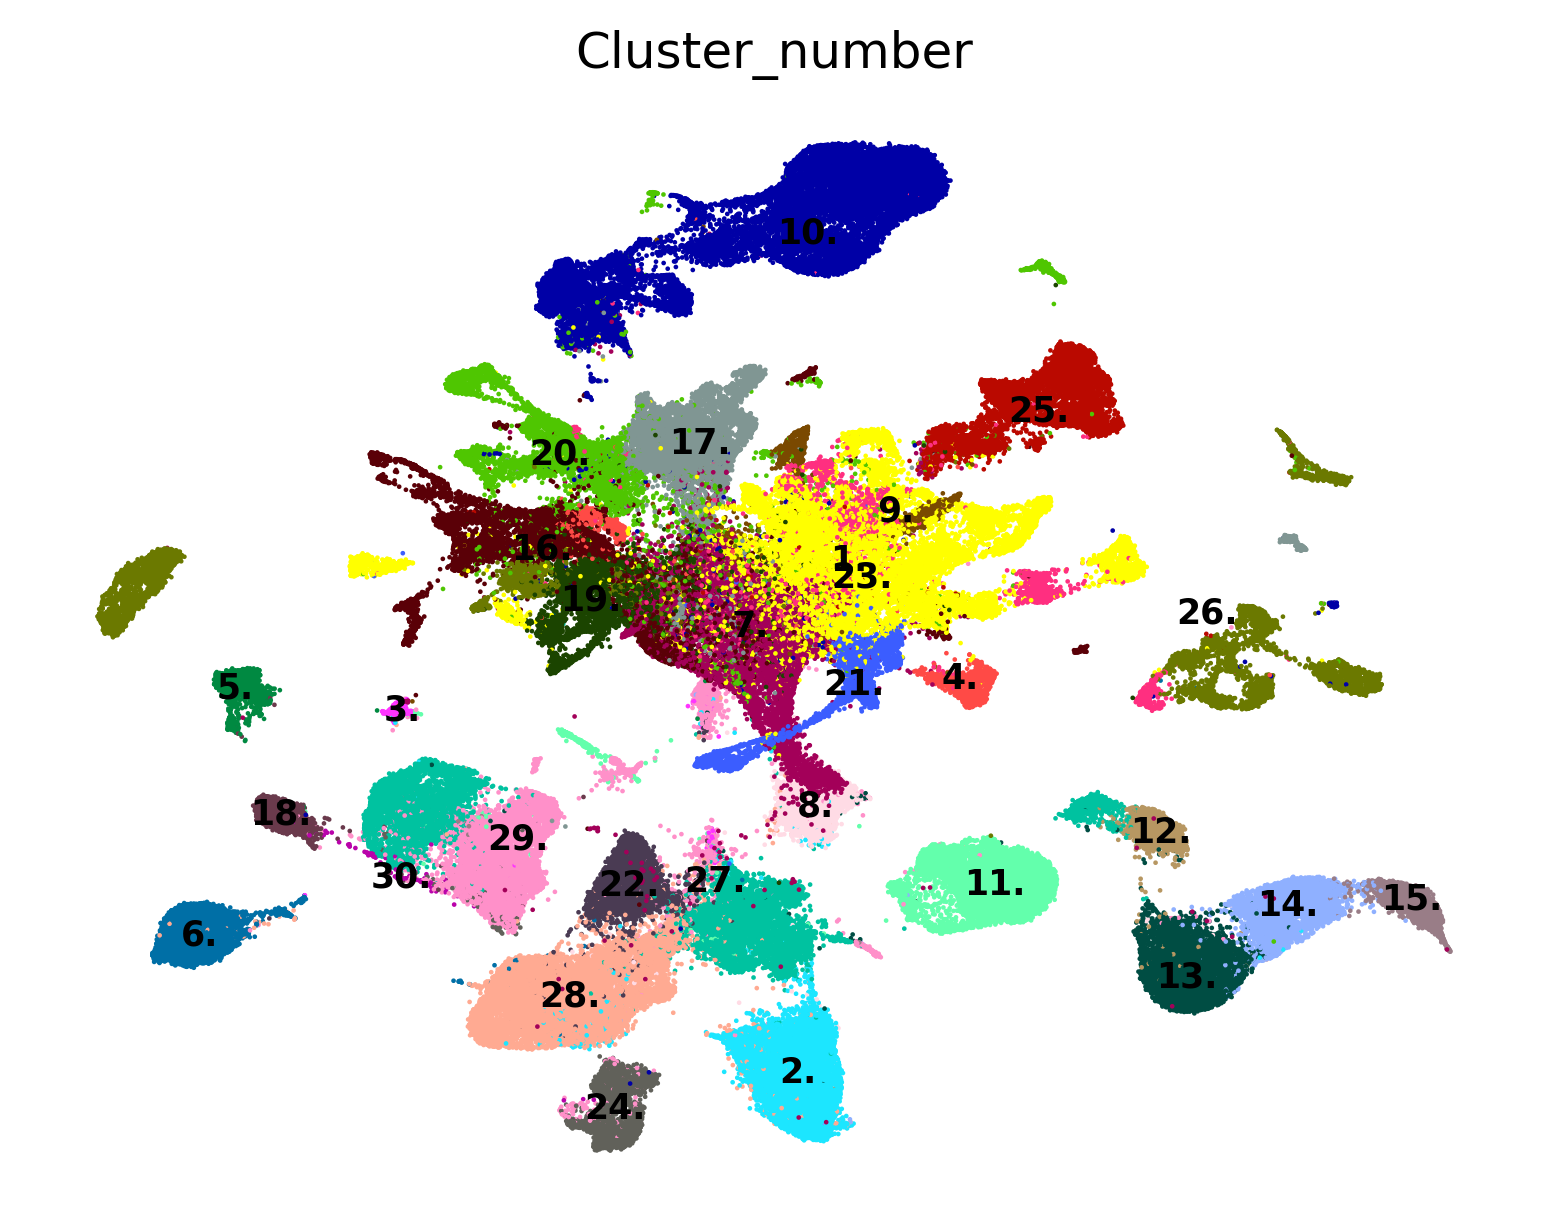

In [92]:
with plt.rc_context({ "figure.dpi": 300}):
    sc.pl.umap(
        adata_ref,
        #basis='X_scANVI_MDE',
        color=["Cluster_number"],save='_herb_clusters_numbered.png',
        frameon=False,legend_fontsize='small',
        ncols=1,legend_loc='on data',
        size=5,cmap='jet'
    )

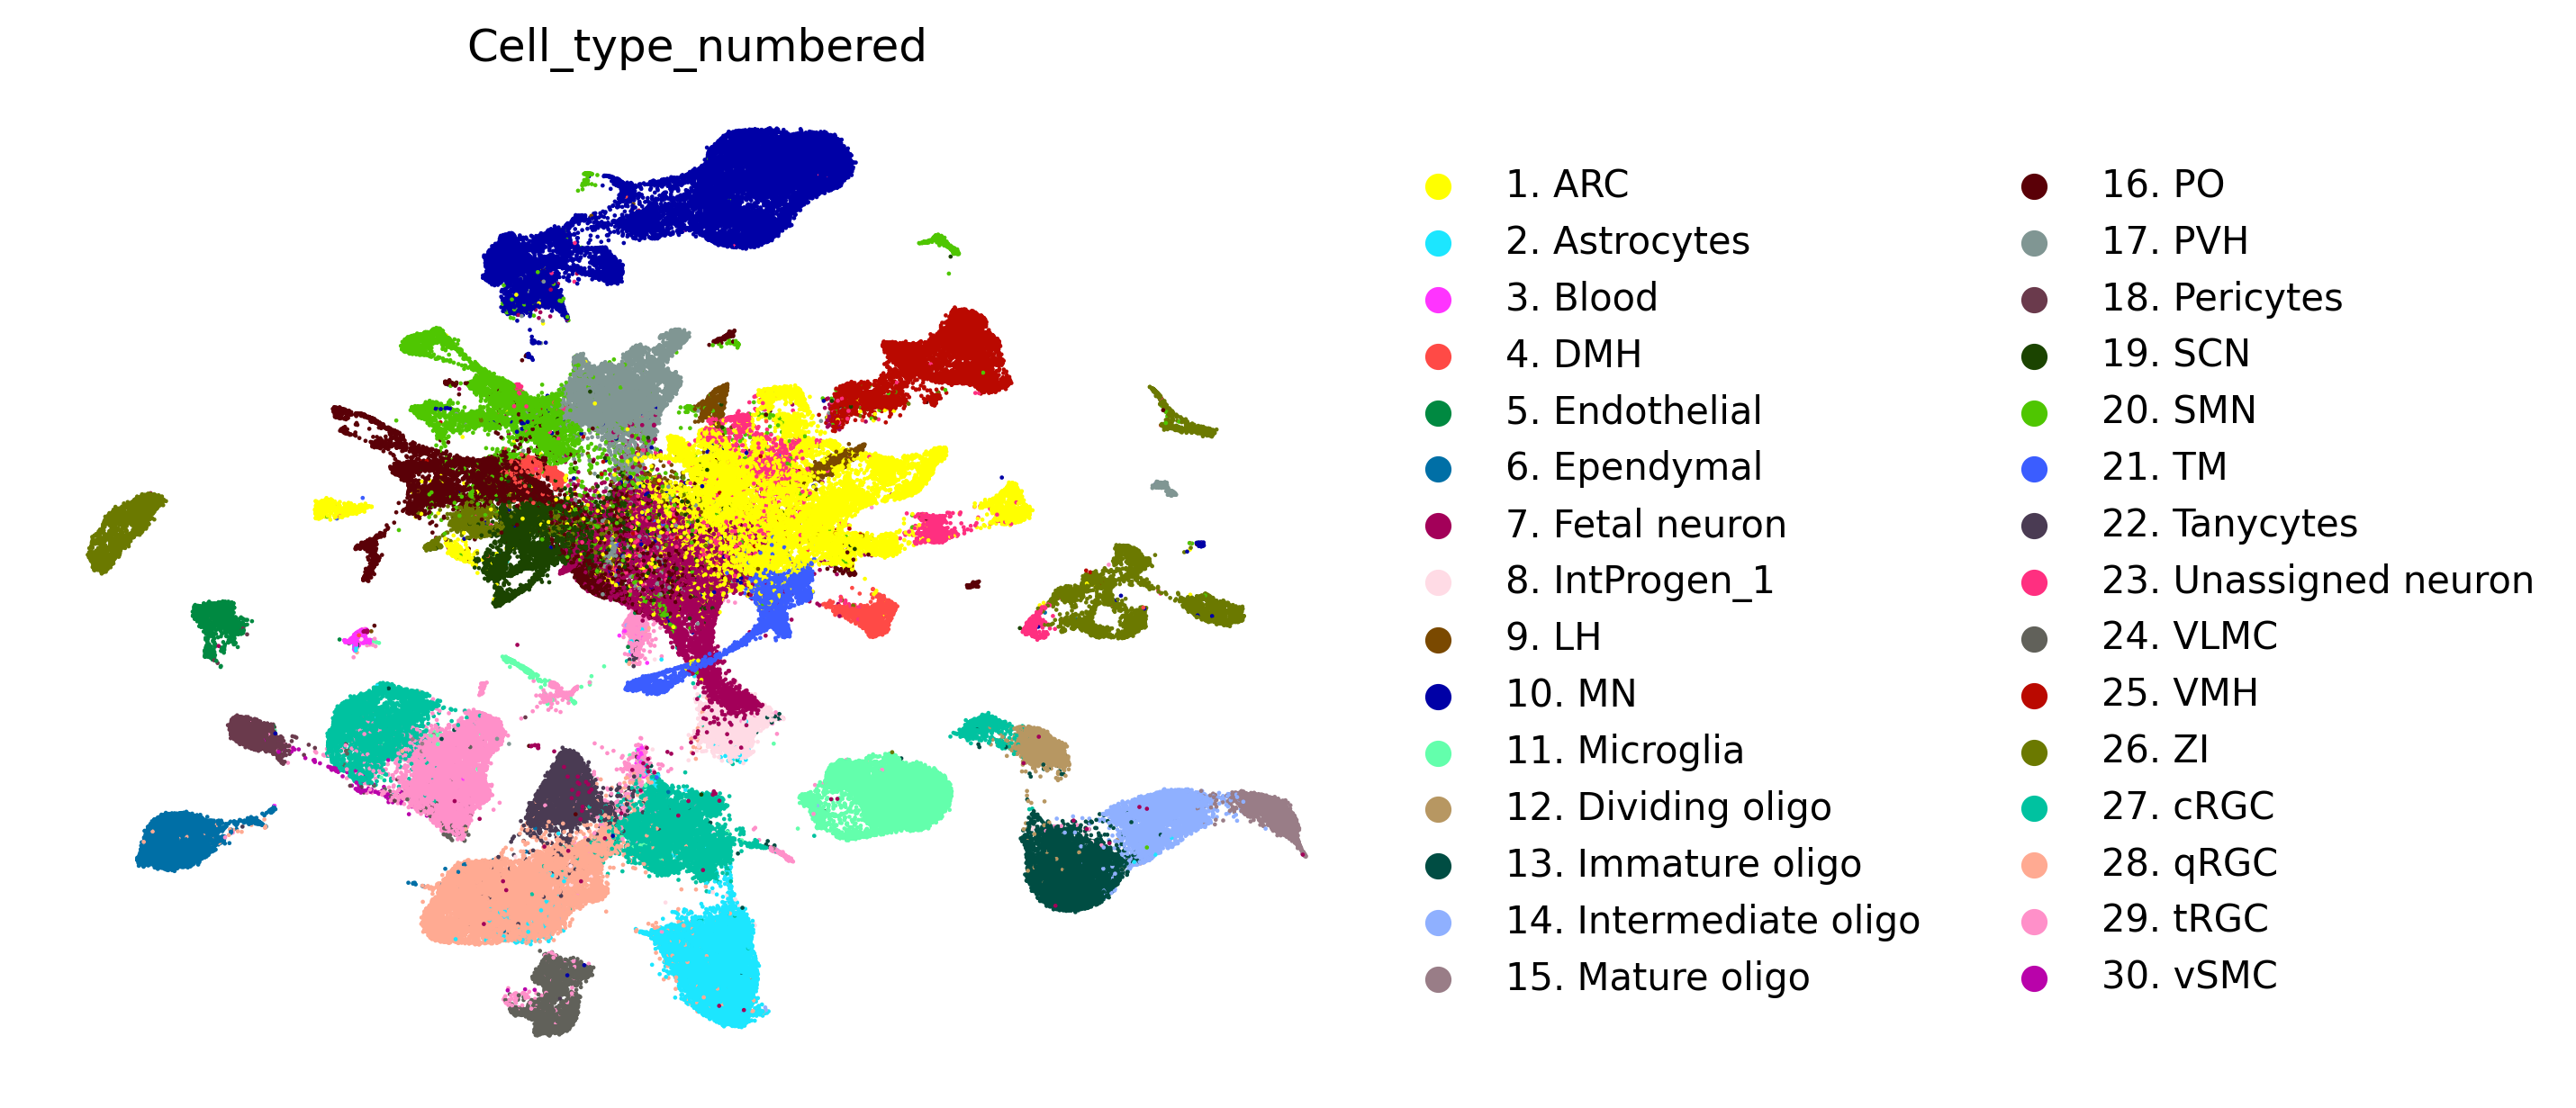

In [91]:
with plt.rc_context({ "figure.dpi": 300}):
    sc.pl.umap(
        adata_ref,
        #basis='X_scANVI_MDE',
        color=["Cell_type_numbered"],
        frameon=False,save='_herb_cluster_legend.png',
        ncols=1,
        size=5,cmap='jet'
    )

In [82]:
adata_query.obsm['X_umap'] = adata_query.obsm['UMAP_SCANVI']

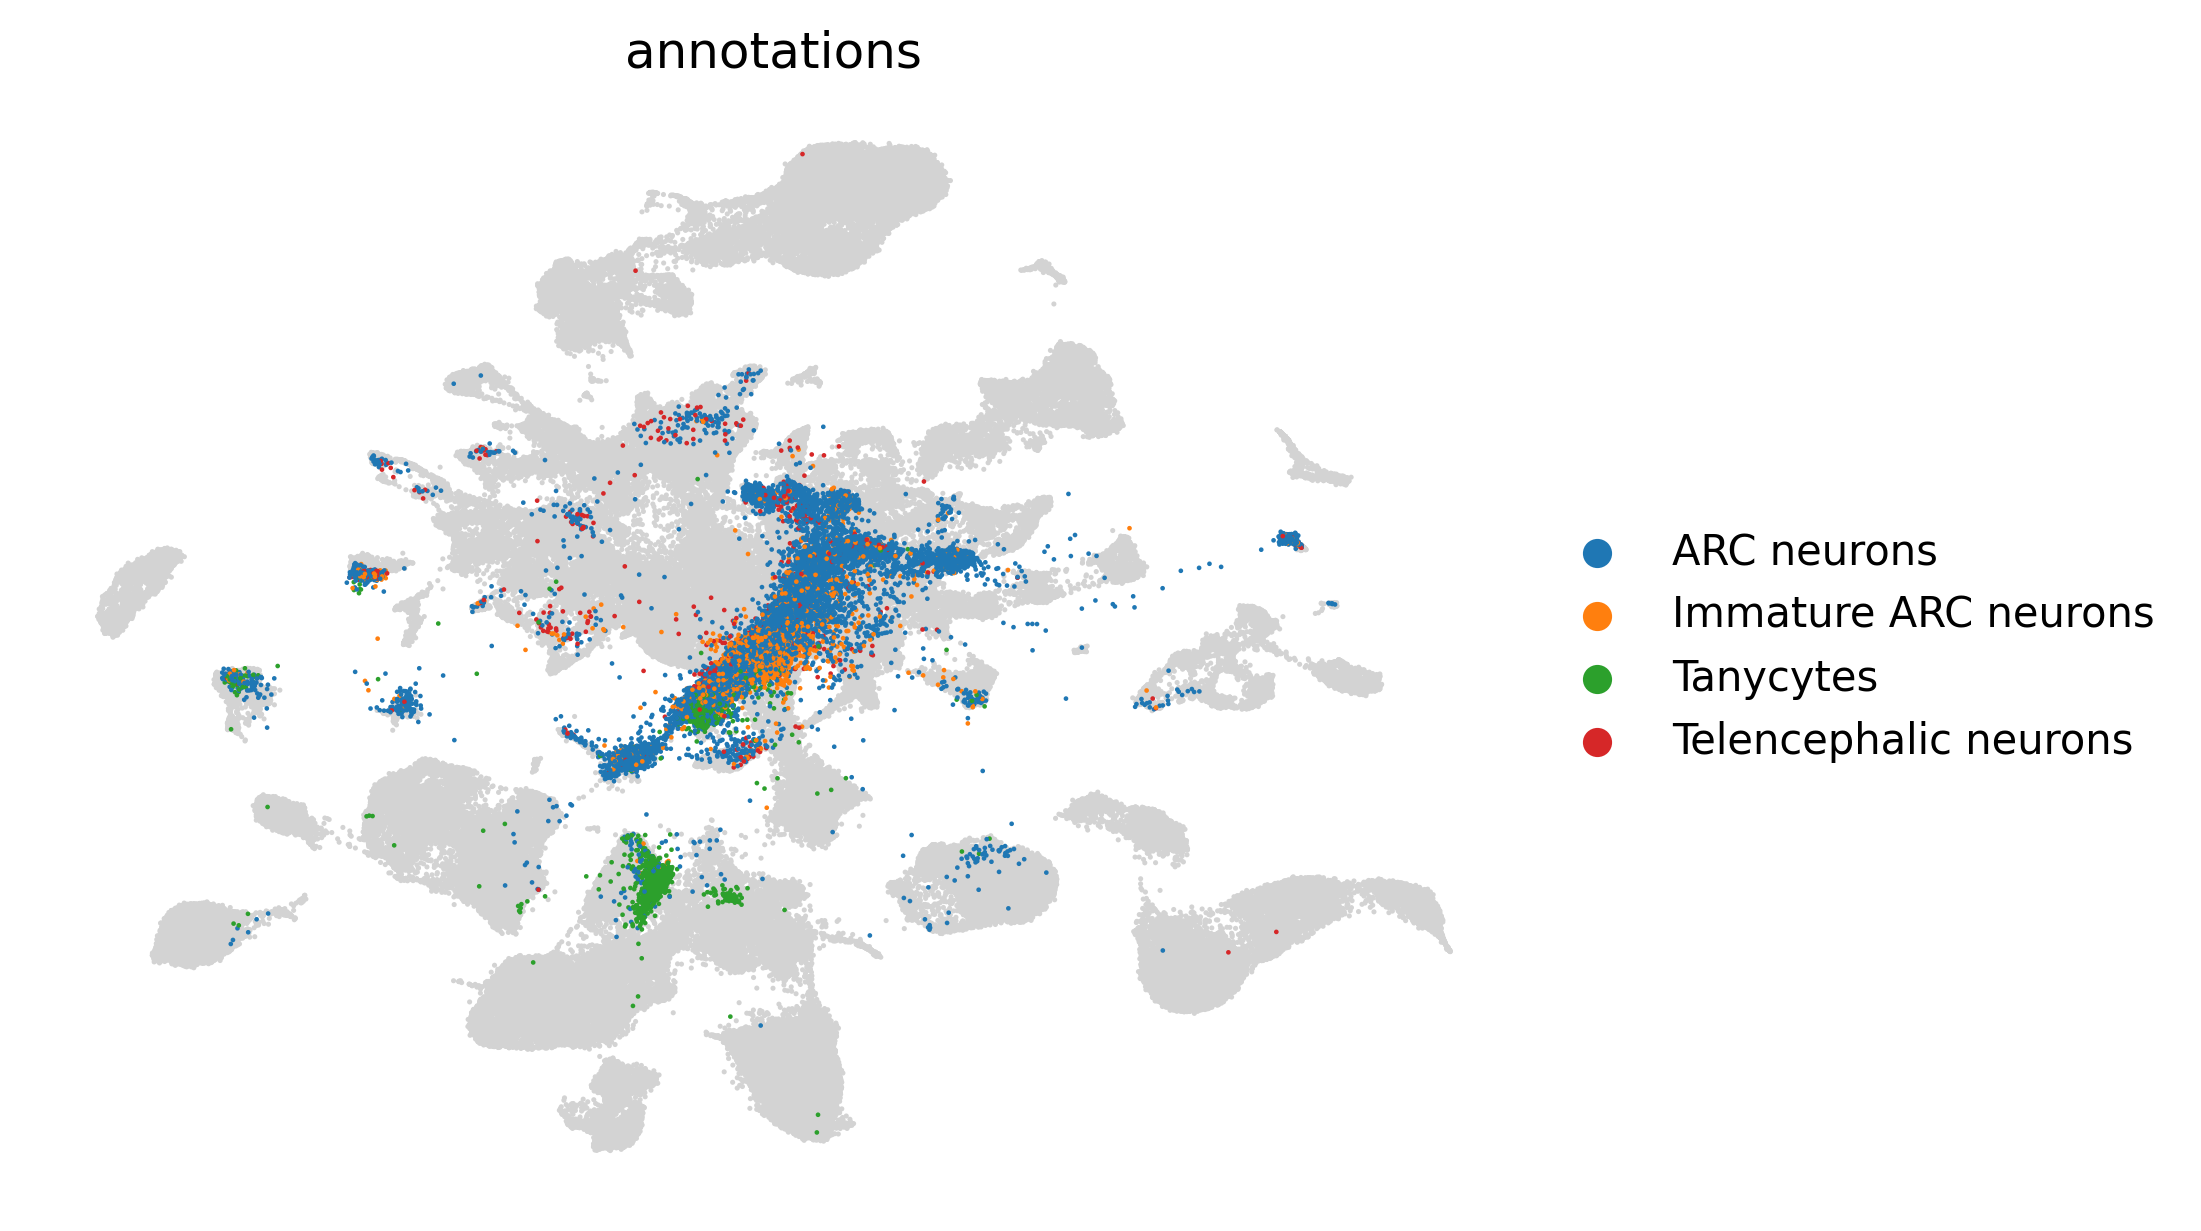

In [89]:
with plt.rc_context({ "figure.dpi": 300}):
    ax = sc.pl.umap(
        adata_ref,
        frameon=False,
        show=False,size=6
    )
    sc.pl.umap(
        adata_query,
        color=["annotations"],
        frameon=False,
        save='_umap_overlay.png',
        ax=ax,na_in_legend=False,
        size=5,
    )


In [83]:
adata_ref.obs["stage"] = 'Unknown'

trimester1 = pd.Series(list(adata_ref[adata_ref.obs["day"].isin(['GW6', 'GW7', 'GW8', 'GW10','GW12'])].obs.index), dtype="category")
adata_ref.obs["stage"].loc[trimester1] = "Trimester 1"

trimester2 = pd.Series(list(adata_ref[adata_ref.obs["day"].isin(['GW15', 'GW16', 'GW18', 'GW19', 'GW20', 'GW22', 'GW25'])].obs.index), dtype="category")
adata_ref.obs["stage"].loc[trimester2] = "Trimester 2"

adult = pd.Series(list(adata_ref[adata_ref.obs["day"].isin(['Adult_29YO', 'Adult_42YO', 'Adult_50YO'])].obs.index), dtype="category")
adata_ref.obs["stage"].loc[adult] = "Adult"


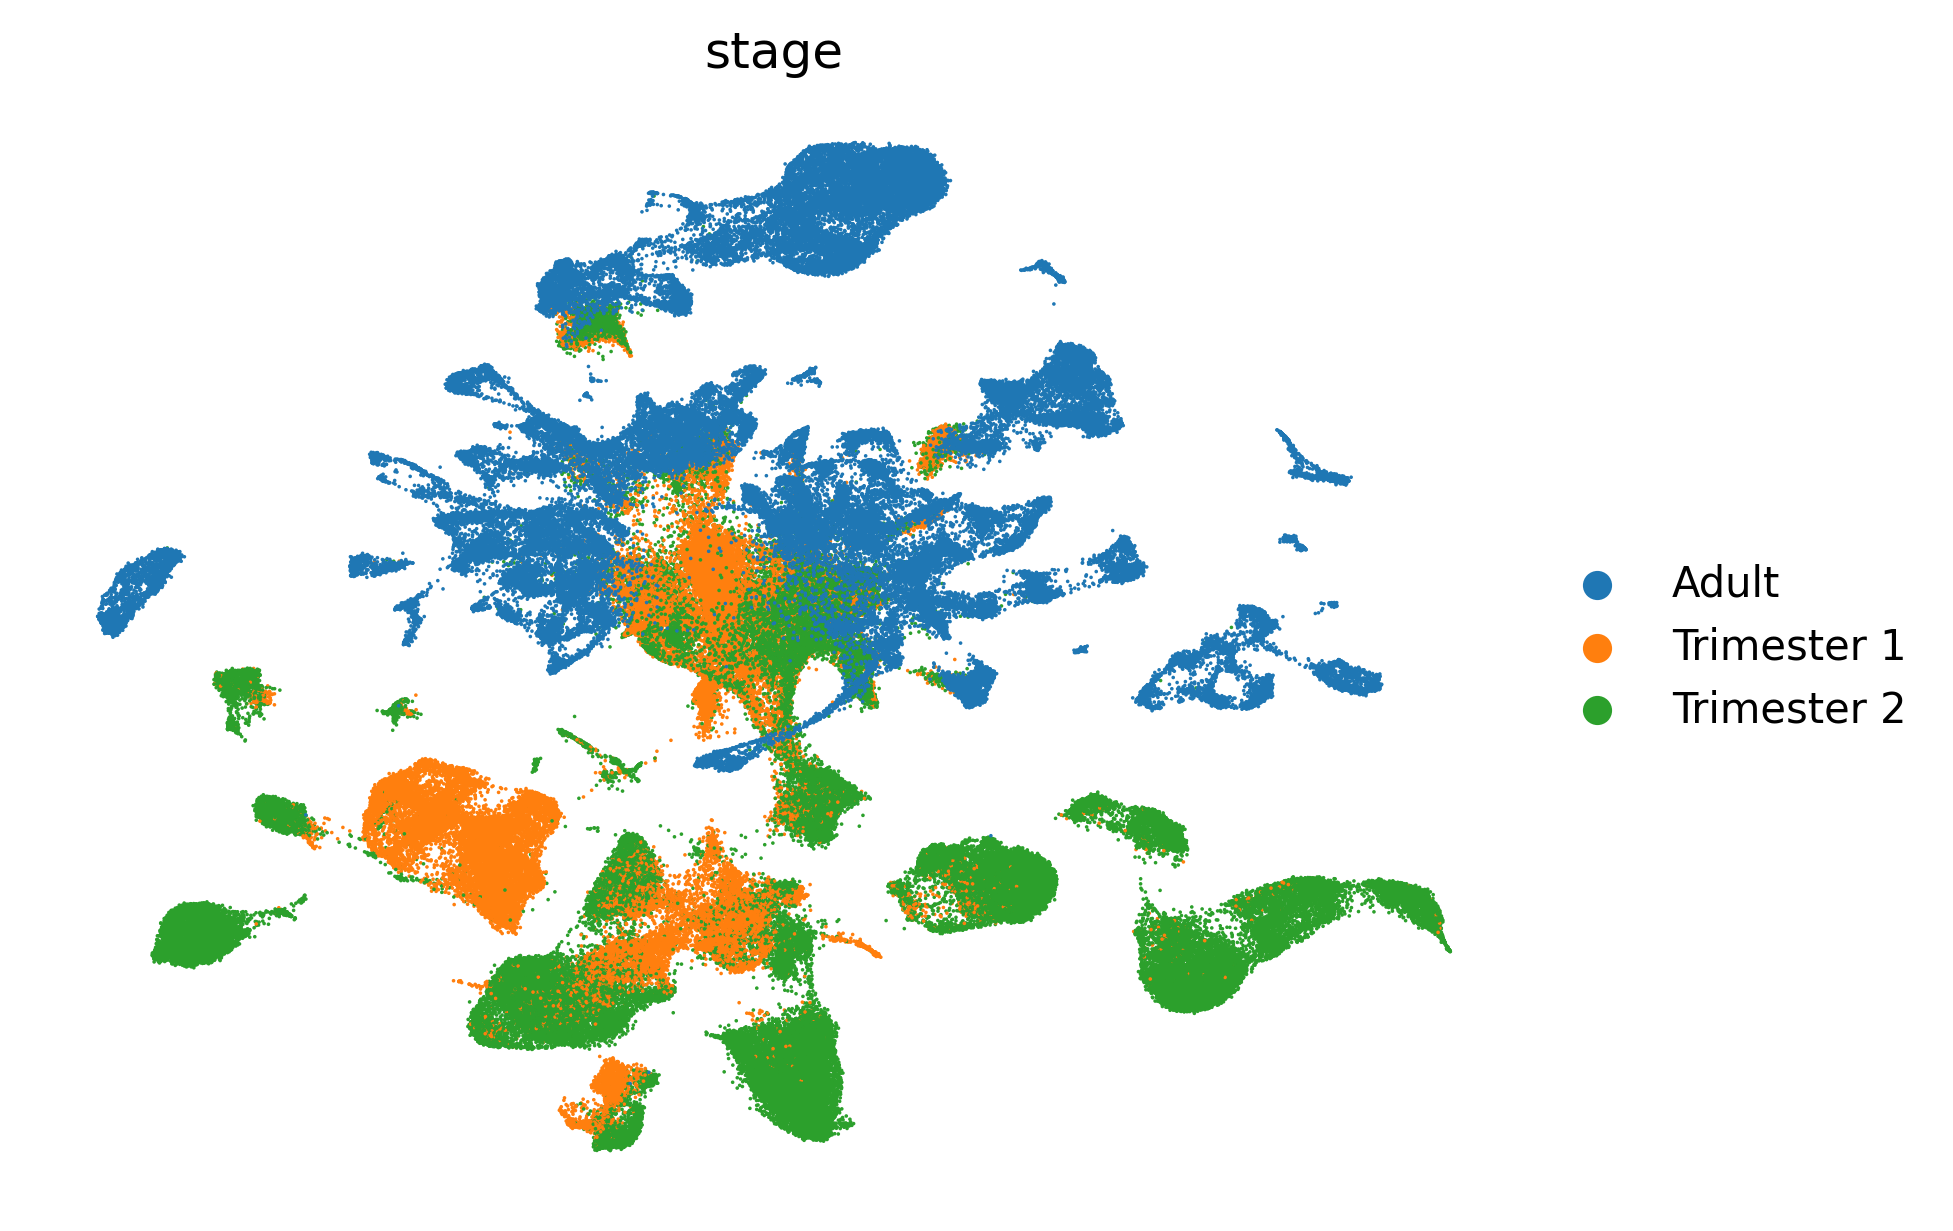

In [90]:
with plt.rc_context({ "figure.dpi": 300}):
    sc.pl.umap(
        adata_ref,
        #basis='X_scANVI_MDE',
        color=["stage"],
        frameon=False,
        ncols=1,#groups=['Trimester 1','Trimester 2'],
        size=3,cmap='jet',save='_herb_timepoint.png'#use_raw=True,save='_herb_timepoint.png'
    )